# Chapter 7

In [ ]:
!pip install --upgrade -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 8.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box, visualization
import os
#import resource
#from keras_cv import visualization
import tqdm

Using TensorFlow backend


In [ ]:
pretrained_retina = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc", bounding_box_format="xywh"
)

142662880/142662880 [==============================] - 6s 0us/step


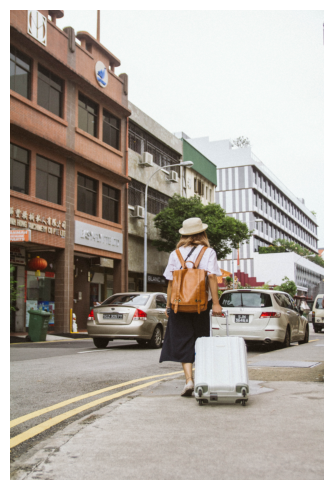

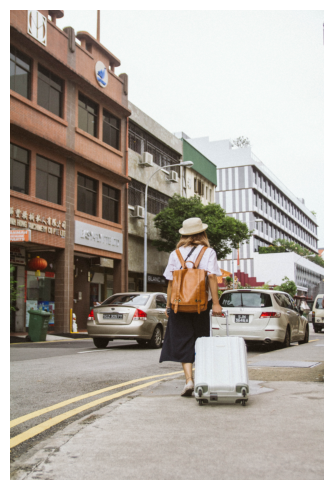

In [ ]:

image = keras.utils.load_img('/content/fig7_1.jpg')
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

In [ ]:
image_batch = inference_resizing([image])

In [ ]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [ ]:
prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.5,
)
pretrained_model.prediction_decoder = prediction_decoder

1/1 [==============================] - 15s 15s/step


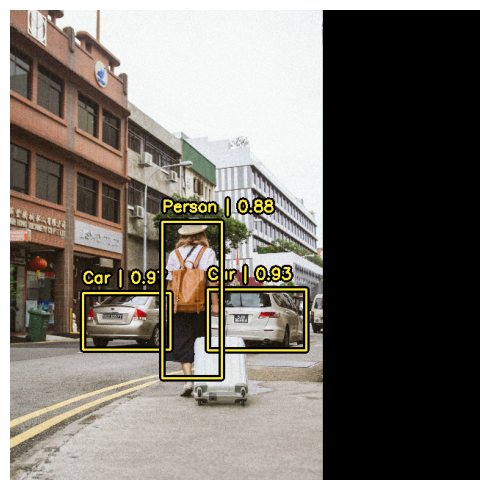

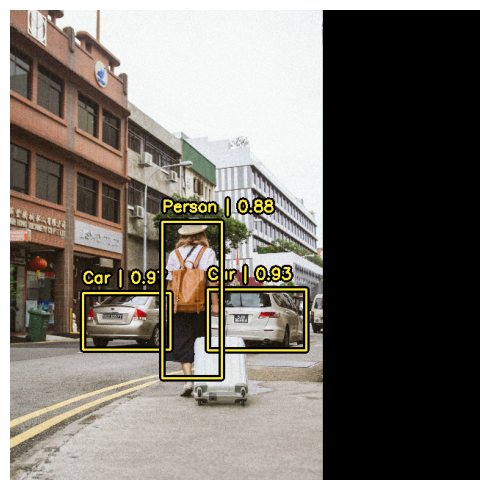

In [ ]:
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

In [ ]:

def print_metrics(metrics):
    maxlen = max([len(key) for key in result.keys()])
    print("Metrics:")
    print("-" * (maxlen + 1))
    for k, v in metrics.items():
        print(f"{k.ljust(maxlen+1)}: {v.numpy():0.2f}")

coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format="xywh", evaluate_freq=20
)
pretrained_model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    metrics=[coco_metrics],
)
coco_metrics.reset_state()
result = pretrained_model.evaluate(eval_ds_fetched, verbose=0)
result = coco_metrics.result(force=True)


In [ ]:
print_metrics(result)

Metrics:
----------------------------
MaP                         : 0.02
MaP@[IoU=50]                : 0.11
MaP@[IoU=75]                : 0.00
MaP@[area=small]            : 0.00
MaP@[area=medium]           : 0.09
MaP@[area=large]            : 0.00
Recall@[max_detections=1]   : 0.02
Recall@[max_detections=10]  : 0.02
Recall@[max_detections=100] : 0.02
Recall@[area=small]         : 0.00
Recall@[area=medium]        : 0.10
Recall@[area=large]         : 0.00


In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=5,
        rows=3,
        cols=1,
        show=True,
        font_scale=0.5,
        class_mapping=class_mapping,
    )

1/1 [==============================] - 4s 4s/step


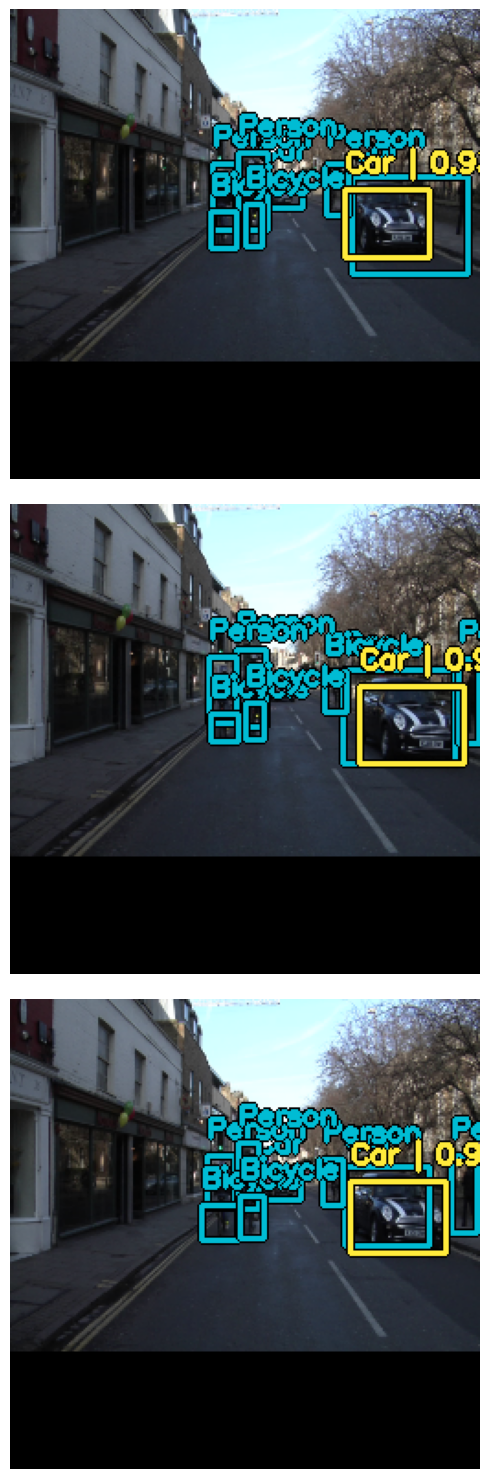

In [ ]:
pretrained_model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)
visualize_detections(pretrained_model, dataset=eval_ds_fetched, bounding_box_format="xywh")

1/1 [==============================] - 3s 3s/step


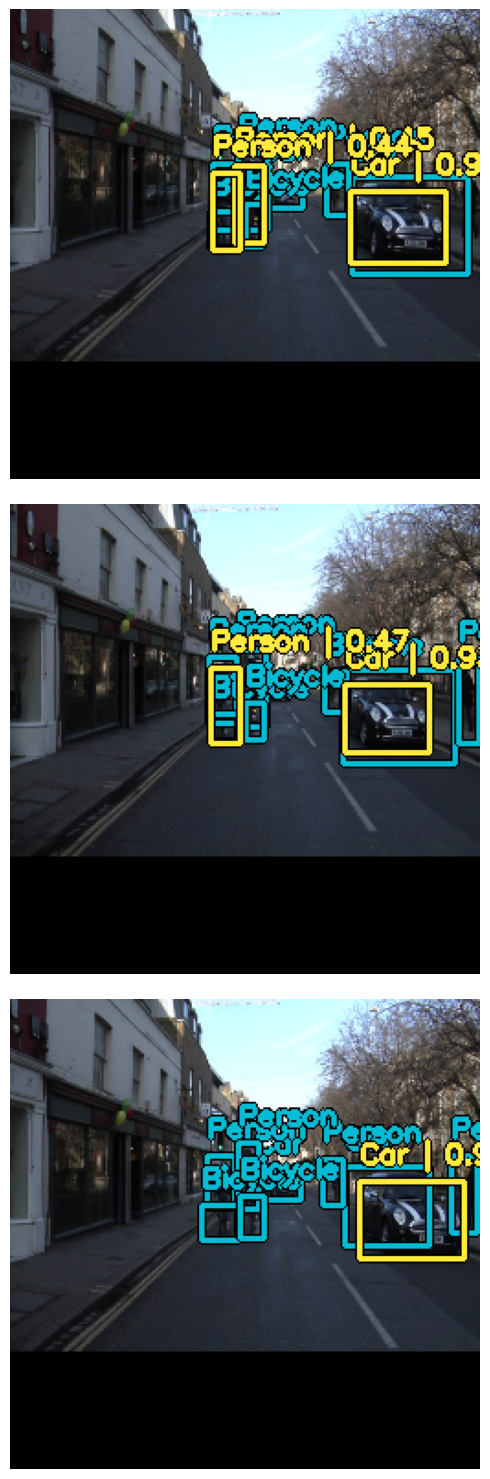

In [ ]:
pretrained_model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.3,
    confidence_threshold=0.4,
)

visualize_detections(pretrained_model, dataset=eval_ds_fetched, bounding_box_format="xywh")

In [ ]:
result = pretrained_model.evaluate(eval_ds_fetched, verbose=0)
result = coco_metrics.result(force=True)

In [ ]:
print_metrics(result)

Metrics:
----------------------------
MaP                         : 0.04
MaP@[IoU=50]                : 0.22
MaP@[IoU=75]                : 0.00
MaP@[area=small]            : 0.02
MaP@[area=medium]           : 0.09
MaP@[area=large]            : 0.00
Recall@[max_detections=1]   : 0.03
Recall@[max_detections=10]  : 0.04
Recall@[max_detections=100] : 0.04
Recall@[area=small]         : 0.02
Recall@[area=medium]        : 0.10
Recall@[area=large]         : 0.00


In [ ]:
model = keras_cv.models.YOLOV8Detector(
    num_classes=20,
    bounding_box_format="xywh",
    backbone=keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_m_backbone_coco"
    ),
    fpn_depth=2
)

47852656/47852656 [==============================] - 1s 0us/step


1/1 [==============================] - 9s 9s/step


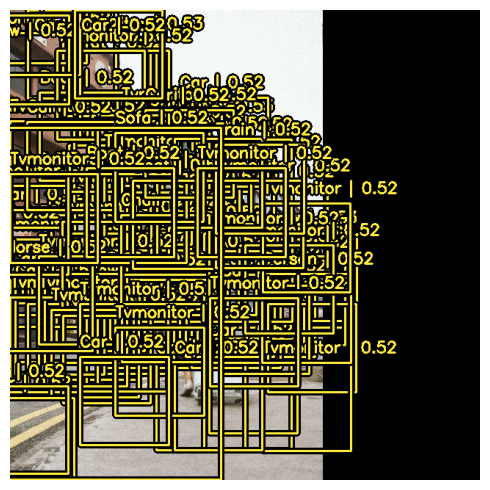

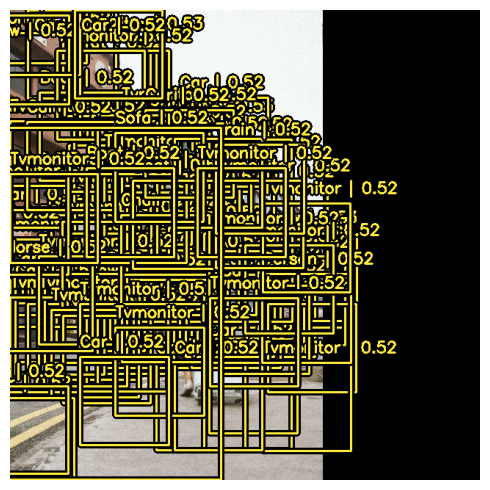

In [ ]:
y_pred = model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

1/1 [==============================] - 10s 10s/step


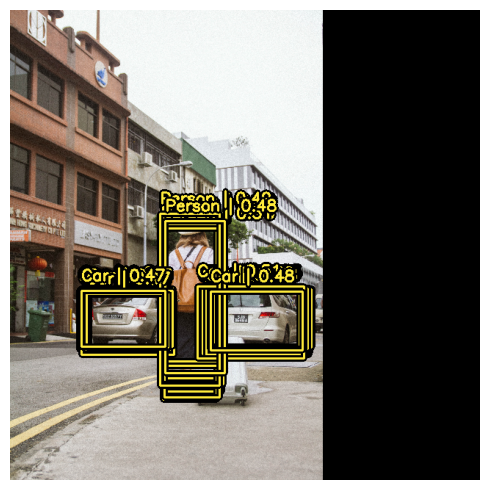

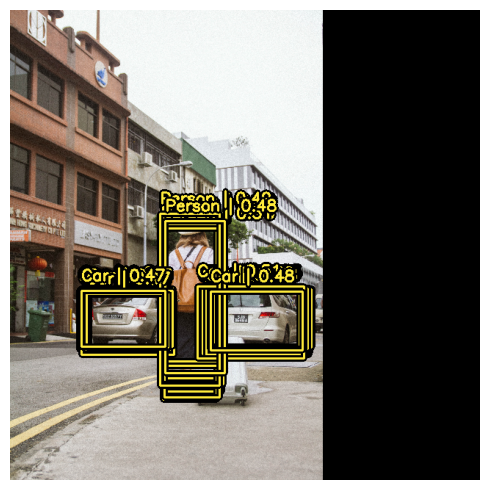

In [ ]:
prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=1.,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.0,
)
pretrained_model.prediction_decoder = prediction_decoder
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

In [ ]:
BATCH_SIZE = 4
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]

    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    print(type(image))
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    print(boxes)
    bounding_boxes = {
        "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
        "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds


#train_ds = load_pascal_voc(
#    split="train", dataset="voc/2007", bounding_box_format="xywh"
#)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

#train_ds = train_ds.shuffle(BATCH_SIZE * 4)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteAB69NB/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteAB69NB/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteAB69NB/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Squeeze:0", shape=(None, 4), dtype=float32)


In [ ]:
!mkdir images

In [ ]:
!ls "/content/images"

In [ ]:
ds = tf.keras.utils.image_dataset_from_directory("/content/images",labels=None,image_size=(360,480))

Found 3 files belonging to 1 classes.


In [ ]:
import os
image_names = [os.path.basename(p) for p in ds.file_paths]
image_names

['0016E5_07963.png', '0016E5_07961.png', '0016E5_07959.png']

In [ ]:
ds_sample_of_three_images = ds.take(1)
for dataset_element in list(ds_sample_of_three_images.as_numpy_iterator()):
  image = dataset_element
  print("shape of image: ", image.shape)

shape of image:  (3, 360, 480, 3)


In [ ]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [ ]:
class_mapping

{0: 'Aeroplane',
 1: 'Bicycle',
 2: 'Bird',
 3: 'Boat',
 4: 'Bottle',
 5: 'Bus',
 6: 'Car',
 7: 'Cat',
 8: 'Chair',
 9: 'Cow',
 10: 'Dining Table',
 11: 'Dog',
 12: 'Horse',
 13: 'Motorbike',
 14: 'Person',
 15: 'Potted Plant',
 16: 'Sheep',
 17: 'Sofa',
 18: 'Train',
 19: 'Tvmonitor',
 20: 'Total'}

In [ ]:
import json
from PIL import Image, ImageDraw

with open("/content/via_project_10Aug2023_9h3m_json (1).json") as file:
  contents = json.load(file)



In [ ]:
contents.keys()

dict_keys(['0016E5_07959.png276620', '0016E5_07961.png277123', '0016E5_07963.png277567'])

In [ ]:
annotations = contents.values()
annotations_dict = {annotation['filename']: annotation['regions'] for annotation in annotations}
annotations_dict

{'0016E5_07959.png': [{'shape_attributes': {'name': 'rect',
    'x': 343,
    'y': 171,
    'width': 86,
    'height': 81},
   'region_attributes': {'class': 'car'}},
  {'shape_attributes': {'name': 'rect',
    'x': 251,
    'y': 175,
    'width': 47,
    'height': 30},
   'region_attributes': {'class': 'car'}},
  {'shape_attributes': {'name': 'rect',
    'x': 451,
    'y': 160,
    'width': 27,
    'height': 79},
   'region_attributes': {'class': 'person'}},
  {'shape_attributes': {'name': 'rect',
    'x': 320,
    'y': 164,
    'width': 21,
    'height': 47},
   'region_attributes': {'class': 'person'}},
  {'shape_attributes': {'name': 'rect',
    'x': 201,
    'y': 161,
    'width': 29,
    'height': 52},
   'region_attributes': {'class': 'person'}},
  {'shape_attributes': {'name': 'rect',
    'x': 234,
    'y': 148,
    'width': 20,
    'height': 67},
   'region_attributes': {'class': 'person'}},
  {'shape_attributes': {'name': 'rect',
    'x': 195,
    'y': 211,
    'width': 38,
 

In [ ]:
inverse_class_mapping = {value: key for key, value in class_mapping.items()}
inverse_class_mapping

{'Aeroplane': 0,
 'Bicycle': 1,
 'Bird': 2,
 'Boat': 3,
 'Bottle': 4,
 'Bus': 5,
 'Car': 6,
 'Cat': 7,
 'Chair': 8,
 'Cow': 9,
 'Dining Table': 10,
 'Dog': 11,
 'Horse': 12,
 'Motorbike': 13,
 'Person': 14,
 'Potted Plant': 15,
 'Sheep': 16,
 'Sofa': 17,
 'Train': 18,
 'Tvmonitor': 19,
 'Total': 20}

In [ ]:

all_bounding_boxes=[]
all_classes=[]
for img_name in image_names:
  image_data = annotations_dict[img_name]
  img_bounding_boxes = []
  classes = []
  for box in image_data:
    img_bounding_boxes.append([box['shape_attributes']['x'],
                               box['shape_attributes']['y'],
                               box['shape_attributes']['width'],
                               box['shape_attributes']['height']])
    classes.append(inverse_class_mapping[(box['region_attributes']['class']).capitalize()])
  all_bounding_boxes.append(img_bounding_boxes)
  all_classes.append(classes)

In [ ]:
all_classes

[[6, 14, 6, 14, 14, 1, 1],
 [6, 14, 1, 14, 14, 1, 1],
 [6, 6, 14, 14, 14, 14, 1, 1]]

In [ ]:
def attach_annotations_to_image_batch(image):
    bounding_boxes = {
        "classes": tf.cast(tf.ragged.constant(all_classes), dtype=tf.float32),
        "boxes": tf.cast(tf.ragged.constant(all_bounding_boxes), dtype=tf.float32)
    }
    print(image)
    print(bounding_boxes)

    return {"images": image, "bounding_boxes": bounding_boxes}

In [ ]:

    ds_final = ds.map(
        lambda batch: attach_annotations_to_image_batch(batch),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

Tensor("args_0:0", shape=(None, 360, 480, 3), dtype=float32)
{'classes': tf.RaggedTensor(values=Tensor("Cast:0", shape=(22,), dtype=float32), row_splits=Tensor("RaggedConstant/Const:0", shape=(4,), dtype=int64)), 'boxes': tf.RaggedTensor(values=tf.RaggedTensor(values=Tensor("Cast_1:0", shape=(88,), dtype=float32), row_splits=Tensor("RaggedConstant_1/Const:0", shape=(23,), dtype=int64)), row_splits=Tensor("RaggedConstant_1/Const_1:0", shape=(4,), dtype=int64))}


In [ ]:
inputs['images'].shape

TensorShape([3, 256, 256, 3])

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.3,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


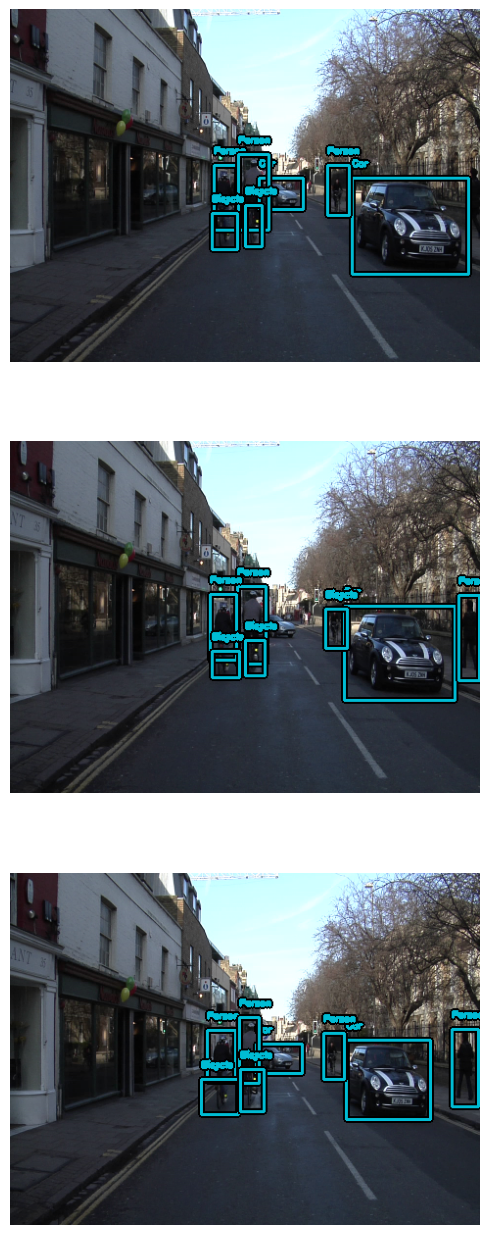

In [ ]:
visualize_dataset(
    ds_final, bounding_box_format="xywh", value_range=(0, 255), rows=3, cols=1
)

In [ ]:
resizing = keras_cv.layers.Resizing(
    256, 256, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
ds_resized = ds_final.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

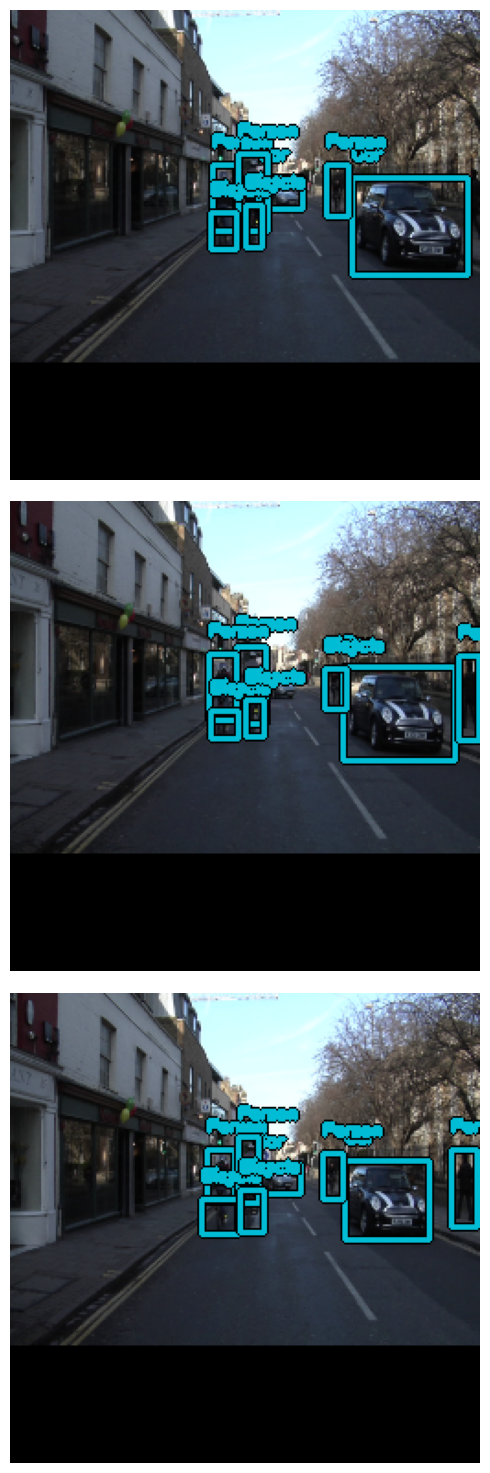

In [ ]:
visualize_dataset(
    ds_resized, bounding_box_format="xywh", value_range=(0, 255), rows=3, cols=1
)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


eval_ds_tuple = ds_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

eval_ds_fetched = eval_ds_tuple.prefetch(tf.data.AUTOTUNE)

In [ ]:
eval_ds_fetched

<_PrefetchDataset element_spec=(TensorSpec(shape=(3, 256, 256, 3), dtype=tf.float32, name=None), {'boxes': TensorSpec(shape=(3, 32, 4), dtype=tf.float32, name=None), 'classes': TensorSpec(shape=(3, 32), dtype=tf.float32, name=None)})>

In [ ]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)
pretrained_model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
)
pretrained_model.fit(eval_ds_fetched.take(1),)
#pretrained_model.summary()

1/1 [==============================] - 25s 25s/step - loss: 0.3627 - box_loss: 0.1862 - classification_loss: 0.1765 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - percent_boxes_matched_with_anchor: 0.7708


In [ ]:
pretrained_model.summary()

Model: "retina_net_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images (InputLayer)            [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model_1 (Functional)           {'P3': (None, None,  23561152    ['images[0][0]']                 
                                 None, 512),                                                      
                                 'P4': (None, None,                                               
                                 None, 1024),                                                     
                                 'P5': (None, None,                                    

In [ ]:

def print_metrics(metrics):
    maxlen = max([len(key) for key in result.keys()])
    print("Metrics:")
    print("-" * (maxlen + 1))
    for k, v in metrics.items():
        print(f"{k.ljust(maxlen+1)}: {v.numpy():0.2f}")

coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format="xywh", evaluate_freq=20
)
pretrained_model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    metrics=[coco_metrics],
)
coco_metrics.reset_state()
result = pretrained_model.evaluate(eval_ds_fetched.take(1), verbose=0)
result = coco_metrics.result(force=True)


In [ ]:
result

{'MaP': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'MaP@[IoU=50]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'MaP@[IoU=75]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'MaP@[area=small]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'MaP@[area=medium]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'MaP@[area=large]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'Recall@[max_detections=1]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'Recall@[max_detections=10]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'Recall@[max_detections=100]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'Recall@[area=small]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'Recall@[area=medium]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'Recall@[area=large]': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [ ]:
def print_metrics(metrics):
    maxlen = max([len(key) for key in result.keys()])
    print("Metrics:")
    print("-" * (maxlen + 1))
    for k, v in metrics.items():
        print(f"{k.ljust(maxlen+1)}: {v.numpy():0.2f}")

In [ ]:
print_metrics(result)

Metrics:
----------------------------
MaP                         : 0.00
MaP@[IoU=50]                : 0.00
MaP@[IoU=75]                : 0.00
MaP@[area=small]            : 0.00
MaP@[area=medium]           : 0.00
MaP@[area=large]            : 0.00
Recall@[max_detections=1]   : 0.00
Recall@[max_detections=10]  : 0.00
Recall@[max_detections=100] : 0.00
Recall@[area=small]         : 0.00
Recall@[area=medium]        : 0.00
Recall@[area=large]         : 0.00
